In [1]:
%matplotlib inline
import importlib as imp
import matplotlib.pylab as plt 
import numpy as np 
import pandas as pd 
import seaborn as sns
sns.set_style('ticks');
current_colors = sns.color_palette()
sns.set_palette('Accent');

# Adjust all text and axes colors to black. default is some studip gray that appears to faint when printed 
from matplotlib import rc , rcParams
rc('axes',edgecolor='black')
rc('xtick',color='black',labelsize=15)
rc('ytick',color='black',labelsize=15)
rc('text',color='black')
rc('axes',labelcolor='black',linewidth=2.0)
rc('font',size=15)
#rcParams["patch.force_edgecolor"] = True

import Calculate_ABA_Finkelsteinlab_Diewertje as CalcABA
imp.reload(CalcABA);
import plotting_ABA_Diewertje as pltABA
imp.reload(pltABA);
import plotting_Boyle_Diewertje as plt_B
imp.reload(plt_B);

import sys 
sys.path.append('../code_general/')
import CRISPR_free_energy_landscape_Diewertje as FreeEnergy
imp.reload(FreeEnergy);
import read_model_ID;
imp.reload(read_model_ID);

import sys 
sys.path.append('../code_general_Finkelsteinlab/')
import plotting_Finkelsteinlab as plt_F
imp.reload(plt_F)


import analysis_SA_fits_Diewertje as SAfits
imp.reload(SAfits);



# Get the best simple fit 

In [2]:
simset = []
no_good = []

chi_squared = [] 

#---------- collect simulations ---------------
for sim in range(1,26):
    sa = pd.read_csv('../Diewertje/1_4_2019_simple/fit_1_4_2019_simple_sim_' +str(sim)+'.txt', delimiter='\t', index_col=46)
    filename = '../Diewertje/1_4_2019_simple/fit_1_4_2019_simple_sim_' +str(sim) +'.txt'   
    chi_squared.append(sa.Potential.iloc[-1])
    simset.append(filename)
        
    
best_fit = simset[np.argmin(chi_squared)]
best_fit

'../Diewertje/1_4_2019_simple/fit_1_4_2019_simple_sim_2.txt'

In [3]:
# Load Parameters
import get_parameters_fit_Diewertje as getParm
Nparams=44
Param_simple=getParm.load_simm_anneal(best_fit,Nparams)

In [4]:
# Load data
import Prepare_data_Simple as Pre
rawABA=pd.read_csv('../Data_ABA_Finkelsteinlab/TargetE-dCas9_AbsoluteABA_Canonical_OT-r_0-2.csv')
rawABA

# prepare data
import Prepare_data_Simple as pre
xdata,ydata,yerr=pre.Prepare_Cdata('../Data_ABA_Finkelsteinlab/','TargetE-dCas9_AbsoluteABA_Canonical_OT-r_0-2.csv')


In [5]:
print('From cluster we get that this fit has chi-squared of:',min(chi_squared)) # compare this to boyle parameters

file_boyle = '../data/25_10_2018/fit_25_10_2018_sim_22.txt'
parametersB = plt_B.load_simm_anneal(file_boyle, Nparams)
import Chisq_F_Simple as chiS
concentrations=np.array([0.1,0.3,1,3,10,30,100,300])
reference=1
Boyle_chi=[]
for i in range(0,len(xdata)):
    Boyle_chi.append(chiS.calc_Chi_square(parametersB,xdata[i],ydata[i],yerr[i],
                                          concentrations,reference,0,guide_length=20,
                                          model_id='init_limit_general_energies_v2'))
print('The chi-squared for Boyle is: ',sum(Boyle_chi))

chi_simple_fit=[]

for i in range(0,len(xdata)):
    chi_simple_fit.append(chiS.calc_Chi_square(Param_simple,xdata[i],ydata[i],yerr[i],
                                          concentrations,reference,0,guide_length=20,
                                          model_id='init_limit_general_energies_v2'))
print('calculating we get the following chi-squared for the fit: ',sum(chi_simple_fit))


From cluster we get that this fit has chi-squared of: 72276.3652505
The chi-squared for Boyle is:  36097510.64929832
calculating we get the following chi-squared for the fit:  72276.36525038323


# Prediction

ontarget ABA is: 5.2018819567222305
[ 6.50874696e-05  8.52528132e-07  5.43452217e-09  1.81454851e-12
  8.88178420e-16  0.00000000e+00  0.00000000e+00 -8.88178420e-16
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.93223215e-11  0.00000000e+00
 -1.77635684e-13  0.00000000e+00  0.00000000e+00  0.00000000e+00]


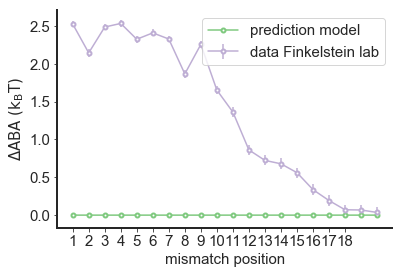

In [6]:
# ONly moddel fit
import plotting_simple_fit as pltS
T=60*10
guide_length=20
model_id = 'init_limit_general_energies_v2'

plt.figure()
_ = pltS.predict_single_mm(Param_simple,model_id, T, guide_length, show_plot=True, show_data=True, data_file=rawABA)


In [7]:
# to see the ABA for every mismatch position, to see why the graph is at almost 0
ABA_fit_simple=[]
for mm_pos in range(1, guide_length + 1):
    ABA_fit_simple.append(CalcABA.calc_ABA(Param_simple,concentrations,
                                    reference,[mm_pos],model_id,
                                    guide_length,T))

#ABA_fit_simple # --> shows that we get all the same delta ABA, so that equilibrium is not reached yet

' \nTHIS IS BECAUSE I DID NOT FIT THE RATE, SO THE RATES ARE JUST A RANDOM NUMBER, \nAND THEREFORE IT IS NOT EQUILIBRATED AFTER 10 MIN, WHICH WE SIMULATED WITH \nTHE calcABA FUNCTION THAT I TRIED USING BEFORE\n'

<Figure size 432x288 with 0 Axes>

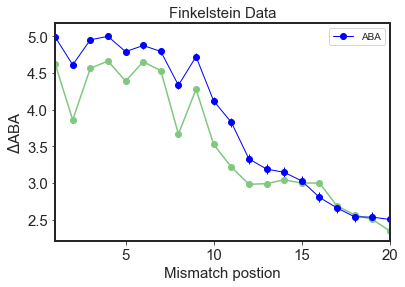

In [8]:
# to calculate the ABA with assuming equilibrium as we do in the chi-squared function
ABA_simple=[]
epsilon = Param_simple[:-3]
for mm_pos in range(1, guide_length + 1):
    energies_simple=CalcABA.get_energies(epsilon,[mm_pos], guide_length)
    ABA_simple.append(-np.log(np.sum(np.exp(-np.cumsum(energies_simple)))))
ABA_simple

ABA_simple_on=-np.log(np.sum(np.exp(-np.cumsum(CalcABA.get_energies(epsilon,[],guide_length)))))
ABA_simple_on

ABA_simple_delta=ABA_simple-ABA_simple_on
ABA_simple_delta

def plot_single_mut_ABA(data, Mut_type, data_name='Finkelstein Data', Canonical=True, Plot=True):
    Mut_names = {'r': 'Mismatch', 'i': 'Insertion', 'd': 'Deletion'}
    Mut_name = Mut_names[Mut_type]

    data['Mutation Type'].fillna('', inplace=True)
    single_mut_data = data[(data['Canonical'] == Canonical) & (data['Mutation Type'] == Mut_type)][
        ['Mutation ID', 'ABA', 'error']]
    single_mut_data['ABA']=single_mut_data['ABA']#-single_mut_data['ABA'].iloc[0] # the row with the ontarget value
    single_mut_data['Position'] = single_mut_data['Mutation ID'].apply(lambda x: int(x.split(':')[1]))
    single_mut_data_mean = single_mut_data[['Position', 'ABA', 'error']].groupby(
        'Position').mean().reset_index()

    if Plot:
        single_mut_data_mean.plot(x='Position', y='ABA', yerr='error', marker='o', linewidth=1,
                                  color='blue')
        plt.xlabel(Mut_name + ' postion', fontsize=15)
        plt.ylabel('$\Delta$ABA', fontsize=15)
        plt.title(data_name, fontsize=15)
        if not Canonical:
            plt.title(data_name + ' - Noncanonical', fontsize=15)

    return single_mut_data_mean

plt.figure()
_=plot_single_mut_ABA(rawABA,'r',Plot=True)
plt.plot(range(1,21),ABA_simple,marker='o')

# Now we do get a fit that looks okay. If there would be equilibrium after 10 
# min, it has to be possible to get this same graph with the calcABA funciton 
# as I tried before, bit this apparently does not work.
''' 
THIS IS BECAUSE I DID NOT FIT THE RATE, SO THE RATES ARE JUST A RANDOM NUMBER, 
AND THEREFORE IT IS NOT EQUILIBRATED AFTER 10 MIN, WHICH WE SIMULATED WITH 
THE calcABA FUNCTION THAT I TRIED USING BEFORE
'''


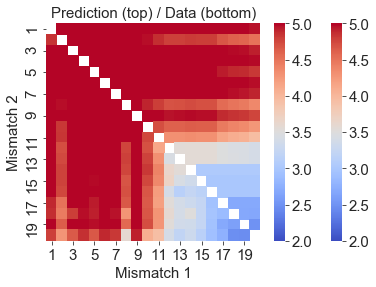

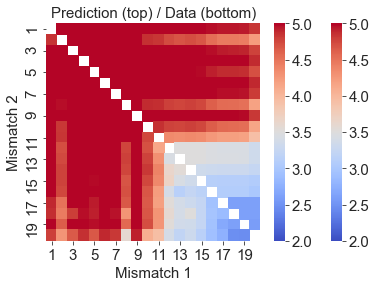

In [23]:
def predict_double_mm(parameters, model_id, T=60 * 10, guide_length=20, show_plot=True, show_data=True,
                      data_file='../Data_ABA_Finkelsteinlab/champ-cas9-cas12a-data/cas9-target-e-replicate-1-delta-abas-processed.csv'):
    concentrations = np.array([0.1, 0.3, 1, 3, 10, 30, 100, 300]) #2 ** np.array(range(0, 11)) * 0.5
    reference_conc = 1 #10
    
    ontarget_ABA = 42#CalcABA.calc_ABA(parameters, concentrations, reference_conc,
                                   # mismatch_positions=[],
                                   # model_id=model_id,
                                   # guide_length=20,
                                    #T=60 * 10)

    ABA_simple = np.zeros((guide_length, guide_length))
    epsilon = Param_simple[:-3]
    for first_mm in range(1, guide_length + 1):
        for second_mm in range(1, guide_length + 1):
            ABA_simple[first_mm - 1, second_mm - 1] = -np.log(np.sum(np.exp(-np.cumsum(CalcABA.get_energies(epsilon,[first_mm,second_mm], guide_length)))))
            
        # this should be calc_delta_ABA if we do not work wit rawABA dataset

    if show_plot:
        axHeatmap = sns.heatmap(ABA_simple, cmap='coolwarm', mask=np.tril(ABA_simple),vmin=2, vmax=5)
        plt.grid()
        ax = plt.gca()
        ax.set_xticklabels(list(map(lambda x: str(int(x)), ax.get_xticks() + 0.5)), fontsize=15);
        ax.set_yticklabels(list(map(lambda x: str(int(x)), 20 - ax.get_yticks() + 0.5)), fontsize=15, rotation=0);
        str_title = 'Prediction (top)'

        if show_data:
            IlyaData = data_file #pd.read_csv(data_file)
            _, double_mut_map = pltF.plot_double_mut_data(IlyaData, data_colname='ABA', Mut_type='r', Canonical=True, Ng=20, data_name='Data', Plot=False,logplot=False, SaveFigures=False, figure_name='./Figure.pdf')
            # data_colname = [delta ABA (kBT)]  if we use not rawABA dataset!
            #plot_double_mut_ABA(data=IlyaData, Mut_type='r', Plot=False)
            sns.heatmap(double_mut_map, cmap='coolwarm', ax=axHeatmap, vmin=2, vmax=5)
            str_title += ' / Data (bottom)'
        plt.title(str_title, fontsize=15)
        plt.xlabel('Mismatch 1', fontsize=15)
        plt.ylabel('Mismatch 2', fontsize=15)
    return ABA_simple

import plotting_Finkelsteinlab_Diewertje as pltF

plt.figure()
_ = predict_double_mm(Param_simple,model_id,T, guide_length, show_plot=True, show_data=True, data_file=rawABA)
plt.figure()
_ = pltABA.predict_double_mm(Param_normal,model_id,T, guide_length, show_plot=True, show_data=True, data_file=rawABA)


C:\Users\Diewertje\Python\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\Diewertje\Python\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


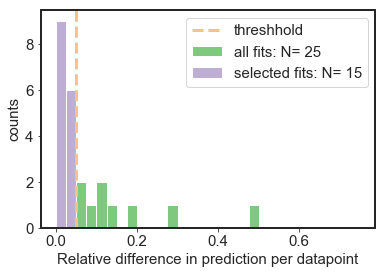

In [10]:
# This does exactly the same as above! To get scores
selected_sims, selected_scores, scores = SAfits.select_on_prediction(simset, 
                                                         chi_squared, 
                                                         percentage=0.05,
                                                         Nparams=44,
                                                         model_id='init_limit_general_energies_v2',
                                                         precalculated=False, 
                                                         score=None,
                                                         save_scores=False, 
                                                         filename='../data/25_10_2018/select_with_predcitions.txt'
                                                         ) # do not use filename now
plt.hist(scores, normed=False, bins=np.arange(0,max(scores),0.025), label='all fits: N= ' +str(len(scores)))
plt.hist(selected_scores,normed=False, bins=np.arange(0,max(scores),0.025), label='selected fits: N= ' +str(len(selected_scores)));

plt.axvline(0.05, linestyle='dashed', linewidth=3, color=sns.color_palette()[2], label='threshhold')


plt.legend(fontsize=15);
plt.xlabel('Relative difference in prediction per datapoint', fontsize=15);
plt.ylabel('counts', fontsize=15);
plt.xticks(fontsize=15);

plt.yticks(fontsize=15);

# WHY SHOULD NORMED BE ON????

In [11]:
# --- make selection --- 
#simset = selected_sims 

# --- store resulting fit parameters in a set of Dataframes --- 
matches, mismatches, rates, landscape, free_energy, fast_Rloop = SAfits.process_SA_fits(simset)
forward_rates = rates[['sol_to_PAM','PAM_to_R1','internal']]
matches.loc[best_fit]

PAM    3.500000
1     -9.636798
2     -4.342149
3      2.985089
4     -3.319056
5     -5.998658
6      4.258883
7      6.667404
8     -0.852752
9      6.824429
10     2.578940
11     2.012886
12    -8.710765
13     8.903644
14    -2.282268
15    -7.263974
16     9.350833
17    -6.520127
18     6.293655
19    -0.050033
20     2.509897
Name: ../Diewertje/1_4_2019_simple/fit_1_4_2019_simple_sim_2.txt, dtype: float64

C:\Users\Diewertje\Python\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


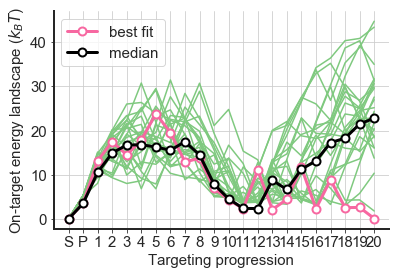

In [12]:
# --- (microscopic) free-energy landscape --- 
plt.figure()
Nparams=44
for filename in simset:
    parameters = plt_B.load_simm_anneal(filename, Nparams)
    #parameters[0]=3.5 # if want to fix epsilon PAM
    Energy_landscape, FreeEnergy_landscape = FreeEnergy.plot_free_energy_landscape(parameters,model_id,show_plot=False);
    plt.plot(np.array(Energy_landscape),color=sns.color_palette()[0])
lowest_chi_squared = np.array( landscape.loc[best_fit] )


plt.plot(np.array(lowest_chi_squared), color='#f768a1' , 
             marker='o', 
             lw=3,
             markersize =8,
             markerfacecolor='white',
             markeredgewidth= 2,
        label='best fit');

LandscapeMED = landscape[landscape.columns[:]].median()
plt.plot(np.array(LandscapeMED),color='black' , 
             marker='o',
             lw=3,
             markersize =8,
             markerfacecolor='white',
             markeredgewidth= 2,
        label='median');

plt.legend(fontsize=15,frameon=True)
plt.xlim(-1,22)
plt.xticks(list(range(0,22)),['S','P']+list(LandscapeMED.index[2:]),  fontsize=15);
plt.yticks(fontsize=15);
plt.xlabel('Targeting progression',fontsize=15)
plt.ylabel('On-target energy landscape ($k_BT$)',fontsize=15)
plt.grid('on')
sns.despine();


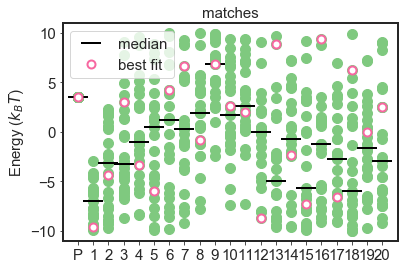

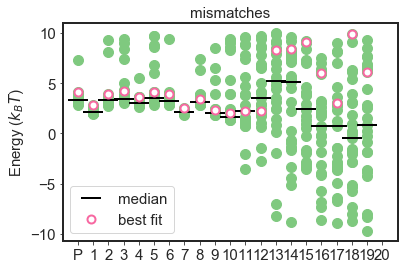

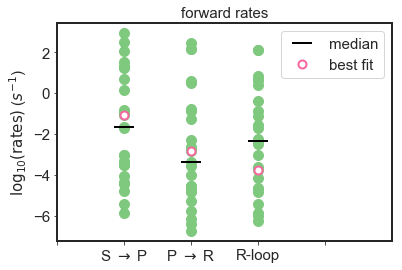

In [13]:
# ---- show fluctuations in parameter sets --- 

# --- Matches ---
# MAYBE WE WANT TO NEGATE (multiply by -1 all the epsilonC to have the same sign convention as EpsilonPAM and EpsilonI)
plt.figure()
for sim in simset:
    matches.loc[sim].plot(marker='o',markersize=10,linestyle='', color=sns.color_palette()[0], alpha=1.0,label='')

matches.median().plot(color='black',
            linestyle='',
             marker='_', 
             lw=4,
             markersize =20,
             markerfacecolor='white',
             markeredgewidth= 2,
        label='median')    

matches.loc[best_fit].plot(color='#f768a1',
            linestyle='',
             marker='o', 
             lw=3,
             markersize =8,
             markerfacecolor='white',
             markeredgewidth= 2,
        label='best fit')



plt.title('matches',fontsize=15)
plt.xticks(list(range(0,21)),['P']+list(range(1,21)),fontsize=15);
plt.xlim(-1,21);
plt.yticks(fontsize=15);
plt.ylabel('Energy ($k_BT$)',fontsize=15);
plt.legend(fontsize=15,frameon=True);

# --- Mismatches --- 
plt.figure()
for sim in simset:
    mismatches.loc[sim].plot(marker='o',markersize=10,linestyle='', color=sns.color_palette()[0], alpha=1.0,label='')

mismatches.median().plot(color='black',
            linestyle='',
             marker='_', 
             lw=4,
             markersize =20,
             markerfacecolor='white',
             markeredgewidth= 2,
        label='median')    
    

mismatches.loc[best_fit].plot(color='#f768a1',
            linestyle='',
             marker='o', 
             lw=3,
             markersize =8,
             markerfacecolor='white',
             markeredgewidth= 2,
        label='best fit')



plt.title('mismatches',fontsize=15)
plt.xticks(list(range(0,21)),['P']+list(range(1,21)),fontsize=15);
plt.xlim(-1,21);
plt.yticks(fontsize=15);
plt.ylabel('Energy ($k_BT$)',fontsize=15);
plt.legend(fontsize=15,frameon=True);


# --- 10log of the forward rates --- 
plt.figure()
for sim in simset:
    forward_rates.loc[sim].apply(np.log10).plot(marker='o',markersize=10,linestyle='', color=sns.color_palette()[0], alpha=1.0,label='')

forward_rates.median().apply(np.log10).plot(color='black',
            linestyle='',
             marker='_', 
             lw=4,
             markersize =20,
             markerfacecolor='white',
             markeredgewidth= 2,
        label='median')    
    
    

forward_rates.loc[best_fit].apply(np.log10).plot(color='#f768a1',
            linestyle='',
             marker='o', 
             lw=3,
             markersize =8,
             markerfacecolor='white',
             markeredgewidth= 2,
        label='best fit')



plt.title('forward rates',fontsize=15)
plt.xticks(range(-1,4),['',r'S $\rightarrow$ P',r'P $\rightarrow$ R','R-loop',''],fontsize=15);
plt.xlim(-1,4);
plt.yticks(fontsize=15);
plt.ylabel(r'$\log_{10}(\rm{rates})$ ($s^{-1}$)',fontsize=15);
plt.legend(fontsize=15,frameon=True);




# Get best normal fit

In [14]:
simset = []
no_good = []

chi_squared = [] 

#---------- collect simulations ---------------
for sim in range(1,22):
    sa = pd.read_csv('../Diewertje/1_4_2019/fit_1_4_2019_sim_' +str(sim)+'.txt', delimiter='\t', index_col=46)
    filename = '../Diewertje/1_4_2019/fit_1_4_2019_sim_' +str(sim) +'.txt'   
    chi_squared.append(sa.Potential.iloc[-1])
    simset.append(filename)
        
    
best_fit = simset[np.argmin(chi_squared)]
best_fit

'../Diewertje/1_4_2019/fit_1_4_2019_sim_18.txt'

In [15]:
min(chi_squared)

63568.4329401

In [16]:
# Load Parameters to calculate the chi-squared for best fit
import get_parameters_fit_Diewertje as getParm
Nparams=44
Param_normal=getParm.load_simm_anneal(best_fit,Nparams)
import Chisq_Finkelstein as chin
chi_normal=[]
for i in range(0,len(xdata)):
    chi_normal.append(chin.calc_Chi_square(Param_normal,xdata[i],ydata[i],yerr[i],
                                concentrations, reference=1, 
                                ontarget_ABA=42,guide_length=20,
                                model_id='init_limit_general_energies_v2'))
#chi_normal


ontarget ABA is: 2.221607916152595
[2.52426964 1.79069393 2.39430958 2.46508175 2.24925682 2.4653812
 2.31934811 1.38622032 1.9818801  1.01261789 0.96164931 0.76718378
 0.69643428 0.73564457 0.65823783 0.46562135 0.39414839 0.38771573
 0.36342977 0.16950708]


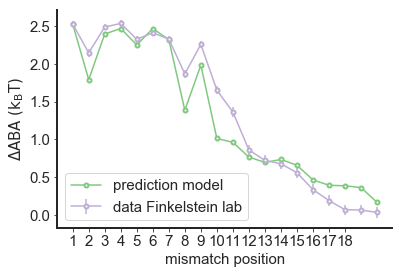

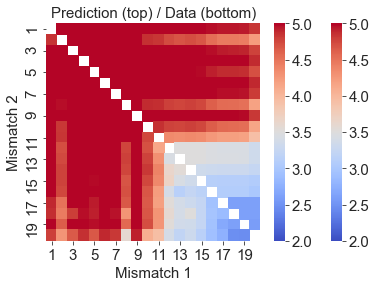

In [17]:
import plotting_simple_fit as pltS
T=60*10
guide_length=20
model_id = 'init_limit_general_energies_v2'

plt.figure()
_ = pltS.predict_single_mm(Param_normal,model_id, T, guide_length, show_plot=True, show_data=True, data_file=rawABA)
plt.figure()
_ = pltABA.predict_double_mm(Param_normal,model_id,T, guide_length, show_plot=True, show_data=True, data_file=rawABA)

# Cannot do those plots, because do not have block data
# plt.figure()
# _ = pltABA.predict_1D_mmblocks(Param_normal, model_id, T, guide_length, show_plot=True, show_data=True, data_file=rawABA)
# plt.figure()
# _ = pltABA.predict_block_mismatches(Param_normal, model_id, T,guide_length, show_plot=True, show_data=True, data_file=rawABA)



In [18]:
# # to plot boyle in this graph
# Param_Boyle=np.loadtxt('parameters_Boyle.txt')
# epsC = Param_Boyle[:21].copy()
# epsC[1:] *= -1

# epsC_fit=np.array([Param_normal[:21]]).copy()
# epsC_fit[1:]*= -1

# plt.plot(range(0,21),np.cumsum(epsC),marker='o')
# #plt.plot(range(0,21),np.cumsum(epsC_fit),marker='o')

# lowest_chi_squared = np.array( landscape.loc[best_fit] )


# plt.plot(np.array(lowest_chi_squared), color='#f768a1' , 
#              marker='o', 
#              lw=3,
#              markersize =8,
#              markerfacecolor='white',
#              markeredgewidth= 2,
#         label='best fit');


C:\Users\Diewertje\Python\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\Diewertje\Python\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


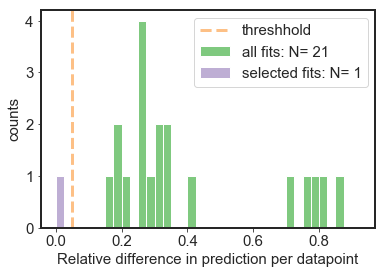

In [19]:
# This does exactly the same as above! To get scores
selected_sims, selected_scores, scores = SAfits.select_on_prediction(simset, 
                                                         chi_squared, 
                                                         percentage=0.05,
                                                         Nparams=44,
                                                         model_id='init_limit_general_energies_v2',
                                                         precalculated=False, 
                                                         score=None,
                                                         save_scores=False, 
                                                         filename='../data/25_10_2018/select_with_predcitions.txt'
                                                         ) # do not use filename now
plt.hist(scores, normed=False, bins=np.arange(0,max(scores),0.025), label='all fits: N= ' +str(len(scores)))
plt.hist(selected_scores,normed=False, bins=np.arange(0,max(scores),0.025), label='selected fits: N= ' +str(len(selected_scores)));

plt.axvline(0.05, linestyle='dashed', linewidth=3, color=sns.color_palette()[2], label='threshhold')


plt.legend(fontsize=15);
plt.xlabel('Relative difference in prediction per datapoint', fontsize=15);
plt.ylabel('counts', fontsize=15);
plt.xticks(fontsize=15);

plt.yticks(fontsize=15);

# WHY SHOULD NORMED BE ON????

In [20]:
# --- make selection --- 
#simset = selected_sims 

# --- store resulting fit parameters in a set of Dataframes --- 
matches, mismatches, rates, landscape, free_energy, fast_Rloop = SAfits.process_SA_fits(simset)
forward_rates = rates[['sol_to_PAM','PAM_to_R1','internal']]
matches.loc[best_fit]


PAM    3.500000
1     -7.547314
2     -0.893433
3      0.063774
4      5.852028
5     -5.226425
6      2.218815
7     -1.542757
8     -1.125128
9      4.308961
10     3.798969
11     1.347627
12    -8.123918
13     7.120407
14     0.454601
15    -7.020035
16     8.804226
17    -3.296189
18     0.958922
19     2.915662
20     2.035438
Name: ../Diewertje/1_4_2019/fit_1_4_2019_sim_18.txt, dtype: float64

C:\Users\Diewertje\Python\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


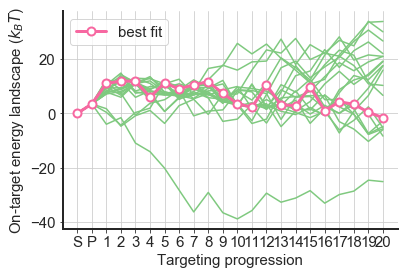

In [21]:
# --- (microscopic) free-energy landscape --- 
plt.figure()
Nparams=44
for filename in simset:
    parameters = plt_B.load_simm_anneal(filename, Nparams)
    parameters[0]=3.5 # if want to fix epsilon PAM
    Energy_landscape, FreeEnergy_landscape = FreeEnergy.plot_free_energy_landscape(parameters,model_id,show_plot=False);
    plt.plot(np.array(Energy_landscape),color=sns.color_palette()[0])
lowest_chi_squared = np.array( landscape.loc[best_fit] )


plt.plot(np.array(lowest_chi_squared), color='#f768a1' , 
             marker='o', 
             lw=3,
             markersize =8,
             markerfacecolor='white',
             markeredgewidth= 2,
        label='best fit');

LandscapeMED = landscape[landscape.columns[:]].median()
# plt.plot(np.array(LandscapeMED),color='black' , 
#              marker='o',
#              lw=3,
#              markersize =8,
#              markerfacecolor='white',
#              markeredgewidth= 2,
#         label='median');

plt.legend(fontsize=15,frameon=True)
plt.xlim(-1,22)
plt.xticks(list(range(0,22)),['S','P']+list(LandscapeMED.index[2:]),  fontsize=15);
plt.yticks(fontsize=15);
plt.xlabel('Targeting progression',fontsize=15)
plt.ylabel('On-target energy landscape ($k_BT$)',fontsize=15)
plt.grid('on')
sns.despine();


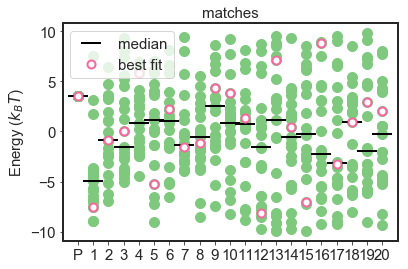

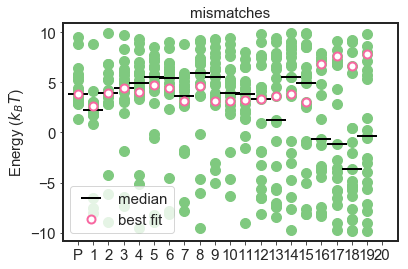

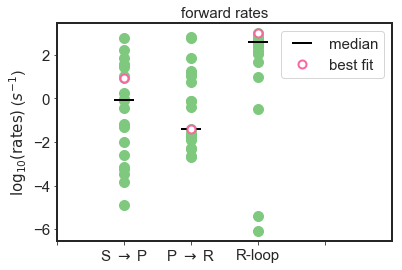

In [22]:
# ---- show fluctuations in parameter sets --- 

# --- Matches ---
# MAYBE WE WANT TO NEGATE (multiply by -1 all the epsilonC to have the same sign convention as EpsilonPAM and EpsilonI)
plt.figure()
for sim in simset:
    matches.loc[sim].plot(marker='o',markersize=10,linestyle='', color=sns.color_palette()[0], alpha=1.0,label='')

matches.median().plot(color='black',
            linestyle='',
             marker='_', 
             lw=4,
             markersize =20,
             markerfacecolor='white',
             markeredgewidth= 2,
        label='median')    

matches.loc[best_fit].plot(color='#f768a1',
            linestyle='',
             marker='o', 
             lw=3,
             markersize =8,
             markerfacecolor='white',
             markeredgewidth= 2,
        label='best fit')



plt.title('matches',fontsize=15)
plt.xticks(list(range(0,21)),['P']+list(range(1,21)),fontsize=15);
plt.xlim(-1,21);
plt.yticks(fontsize=15);
plt.ylabel('Energy ($k_BT$)',fontsize=15);
plt.legend(fontsize=15,frameon=True);

# --- Mismatches --- 
plt.figure()
for sim in simset:
    mismatches.loc[sim].plot(marker='o',markersize=10,linestyle='', color=sns.color_palette()[0], alpha=1.0,label='')

mismatches.median().plot(color='black',
            linestyle='',
             marker='_', 
             lw=4,
             markersize =20,
             markerfacecolor='white',
             markeredgewidth= 2,
        label='median')    
    

mismatches.loc[best_fit].plot(color='#f768a1',
            linestyle='',
             marker='o', 
             lw=3,
             markersize =8,
             markerfacecolor='white',
             markeredgewidth= 2,
        label='best fit')



plt.title('mismatches',fontsize=15)
plt.xticks(list(range(0,21)),['P']+list(range(1,21)),fontsize=15);
plt.xlim(-1,21);
plt.yticks(fontsize=15);
plt.ylabel('Energy ($k_BT$)',fontsize=15);
plt.legend(fontsize=15,frameon=True);


# --- 10log of the forward rates --- 
plt.figure()
for sim in simset:
    forward_rates.loc[sim].apply(np.log10).plot(marker='o',markersize=10,linestyle='', color=sns.color_palette()[0], alpha=1.0,label='')

forward_rates.median().apply(np.log10).plot(color='black',
            linestyle='',
             marker='_', 
             lw=4,
             markersize =20,
             markerfacecolor='white',
             markeredgewidth= 2,
        label='median')    
    
    

forward_rates.loc[best_fit].apply(np.log10).plot(color='#f768a1',
            linestyle='',
             marker='o', 
             lw=3,
             markersize =8,
             markerfacecolor='white',
             markeredgewidth= 2,
        label='best fit')



plt.title('forward rates',fontsize=15)
plt.xticks(range(-1,4),['',r'S $\rightarrow$ P',r'P $\rightarrow$ R','R-loop',''],fontsize=15);
plt.xlim(-1,4);
plt.yticks(fontsize=15);
plt.ylabel(r'$\log_{10}(\rm{rates})$ ($s^{-1}$)',fontsize=15);
plt.legend(fontsize=15,frameon=True);


